In [179]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  

sns.set_style("whitegrid")

In [180]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [181]:
path = 'data/processed'
benchmarks_df = pd.read_csv(os.path.join(path, 'a_benchmarks_2024-09-11.csv'))
schools_df = pd.read_csv(os.path.join(path, 'a_schools_2024-08-29.csv'))
courseSections_df = pd.read_csv(os.path.join(path, 'a_courseSections_2024-08-29.csv'))
courseSectionRosters_df = pd.read_csv(os.path.join(path, 'a_courseSectionRosters_2024-08-29.csv'))
scores_df = pd.read_csv(os.path.join(path, 'a_scores_2024-09-11.csv'))
vendorUsage_df = pd.read_csv(os.path.join(path, 'a_vendorUsage_2024-09-11.csv'))

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_97549/4073666699.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  courseSectionRosters_df = pd.read_csv(os.path.join(path, 'a_courseSectionRosters_2024-08-29.csv'))


In [182]:
print("benchmarks_df columns:")
print(benchmarks_df.columns)
print("\nschools_df columns:")
print(schools_df.columns)
print("\ncourseSections_df columns:")
print(courseSections_df.columns)
print("\ncourseSectionRosters_df columns:")
print(courseSectionRosters_df.columns)
print("\nscores_df columns:")
print(scores_df.columns)
print("\nvendorUsage_df columns:")
print(vendorUsage_df.columns)

benchmarks_df columns:
Index(['districtId', 'year', 'level', 'dataSource', 'value'], dtype='object')

schools_df columns:
Index(['id', 'name', 'districtId', 'costCenter', 'abbreviation',
       'acqRequestSelectable', 'oneRoster_sourcedId', 'oneRoster_ticketId'],
      dtype='object')

courseSections_df columns:
Index(['id', 'vanityId', 'year', 'schoolId'], dtype='object')

courseSectionRosters_df columns:
Index(['id', 'courseSectionId', 'studentId', 'studentLevel', 'ticket'], dtype='object')

scores_df columns:
Index(['studentId', 'studentLevel', 'year', 'measurementTypeId',
       'subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender',
       'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25',
       'value_actMathScore', 'value_actEnglishScore', 'value_actReadingScore',
       'value_actScienceScore', 'value_actCompositeScore', 'value_nweaMath',
       'value_nweaReading', 'value_nweaEnglish', 'value_iReadyMath',
       'value_iReadyReading', 'value_actMasteryComposi

In [183]:
benchmarks_df.rename(columns={'value':'threshold'}, inplace=True)

In [184]:
courseSectionRosters_df.drop(columns=['id', 'ticket'], inplace=True)
courses = courseSectionRosters_df.merge(courseSections_df, left_on='courseSectionId', right_on='id', how='left')
courses.drop(columns=['id'], inplace=True)
courses = courses[~courses['vanityId'].str.contains('District Wide', case=False, na=False)]
courses = courses[~courses['vanityId'].str.contains('Schoolwide', case=False, na=False)]

In [185]:
courses.head()

,courseSectionId,studentId,studentLevel,vanityId,year,schoolId
0,39975,45333,4,MathGrade 4,2015,232
1,39975,56116,4,MathGrade 4,2015,232
2,39975,45345,4,MathGrade 4,2015,232
3,39975,45400,4,MathGrade 4,2015,232
4,39975,45413,4,MathGrade 4,2015,232


## Create boolean proficiency label by merging scores_df and benchmarks_df

In [186]:
# Step 1: Select only columns starting with 'value_' and keep 'studentId', 'studentLevel', 'year'
value_columns = [col for col in scores_df.columns if col.startswith('value_')]
selected_columns = ['studentId', 'studentLevel', 'year'] + value_columns
scores_subset = scores_df[selected_columns]
scores_subset.head()

,studentId,studentLevel,year,value_actMathScore,value_actEnglishScore,value_actReadingScore,value_actScienceScore,value_actCompositeScore,value_nweaMath,value_nweaReading,value_nweaEnglish,value_iReadyMath,value_iReadyReading,value_actMasteryComposite,value_actMasteryReading,value_actMasteryMath,value_actMasteryScience,value_actMasteryEnglish,value_nweaELA,value_scantronMath,value_scantronReading,value_mapMath,value_mapEnglish,value_mapReading,value_mapRLA,value_scantronScience,value_scantronLanguage,value_ReadingFoundations,value_scantronAlgebra,value_eocMath,value_actELAScore,value_mapScience,value_LeapELAScale,value_LeapMathScale,value_LeapALScale,value_LeapE2Scale,value_LeapGmScale,value_LeapBlScale,value_LeapE3Scale,value_LeapUsScale,value_E1Scale,value_UsEsScale,value_accessReadingScale,value_accessReadingProficiency,value_accessCompositeScale,value_accesscompositeProficiency,value_dibelsReading,value_mapHistory,value_LEAPSocSci,value_scantronGeometry,value_MathMilestones,value_ELAMilestones,value_starReading,value_starMath,value_ScienceMilestones,value_LEAPScience,value_SocialMilestones,value_gcaInfo,value_gcaNar,value_gcaOpin,value_aimsWebMath,value_aimsWebReading
0,44774,9,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,44774,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2841.0,2950,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,44774,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2808.0,2936,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,44775,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2580.0,2660,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,44775,8,2017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2705.0,2670,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [187]:
# Step 2: Melt the scores_subset to create a long format
scores_long = scores_subset.melt(
    id_vars=['studentId', 'studentLevel', 'year'], 
    var_name='dataSource', 
    value_name='score'
)

# Step 3: Rename 'studentLevel' to 'level' to match benchmarks_df
scores_long.rename(columns={'studentLevel': 'level'}, inplace=True)

# Step 4: Remove the 'value_' prefix from the dataSource column
# scores_long['dataSource'] = scores_long['dataSource'].str.replace('value_', '', regex=False)

# Step 5: Drop rows with NaN scores
scores_long.dropna(subset=['score'], inplace=True)

scores_long.head(20)

,studentId,level,year,dataSource,score
0,44774,9,2018,value_actMathScore,0.0
1,44774,8,2017,value_actMathScore,0.0
2,44774,8,2017,value_actMathScore,0.0
3,44775,8,2017,value_actMathScore,0.0
4,44775,8,2017,value_actMathScore,0.0
5,44775,9,2018,value_actMathScore,0.0
6,44776,9,2018,value_actMathScore,0.0
7,44776,8,2017,value_actMathScore,0.0
8,44776,8,2017,value_actMathScore,0.0
9,44777,6,2017,value_actMathScore,0.0


In [188]:
# Step 6: Merge the long-format scores with the benchmarks
proficiency_melted_df = pd.merge(
    scores_long, 
    benchmarks_df[['year', 'level', 'dataSource', 'threshold']], 
    on=['year', 'level', 'dataSource'], 
    how='left'
)

# Check for any missing values after the merge
missing_benchmarks = proficiency_melted_df['threshold'].isna().sum()
print(f"Number of scores without corresponding benchmark: {missing_benchmarks}")

proficiency_melted_df.dropna(subset=['threshold'], inplace=True)
proficiency_melted_df.head(10)

Number of scores without corresponding benchmark: 17394463


,studentId,level,year,dataSource,score,threshold
1440,45054,11,2018,value_actMathScore,9.0,17.0
1441,45054,11,2018,value_actMathScore,0.0,17.0
2968,45440,11,2018,value_actMathScore,16.0,17.0
4848,45953,11,2018,value_actMathScore,17.0,17.0
5018,46042,11,2018,value_actMathScore,17.0,17.0
5019,46042,11,2018,value_actMathScore,18.0,17.0
5028,46066,11,2018,value_actMathScore,0.0,17.0
5033,46082,11,2018,value_actMathScore,0.0,17.0
5034,46082,11,2018,value_actMathScore,14.0,17.0
5063,46158,11,2018,value_actMathScore,0.0,17.0


In [189]:
# Step 7: Create the proficiency label
proficiency_melted_df['is_proficient'] = proficiency_melted_df['score'] >= proficiency_melted_df['threshold']
proficiency_melted_df['proficient_score'] = proficiency_melted_df['score'] / proficiency_melted_df['threshold']
print(proficiency_melted_df.shape)
proficiency_melted_df.head(10)

(476297, 8)


,studentId,level,year,dataSource,score,threshold,is_proficient,proficient_score
1440,45054,11,2018,value_actMathScore,9.0,17.0,False,0.529412
1441,45054,11,2018,value_actMathScore,0.0,17.0,False,0.000000
2968,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176
4848,45953,11,2018,value_actMathScore,17.0,17.0,True,1.000000
5018,46042,11,2018,value_actMathScore,17.0,17.0,True,1.000000
5019,46042,11,2018,value_actMathScore,18.0,17.0,True,1.058824
5028,46066,11,2018,value_actMathScore,0.0,17.0,False,0.000000
5033,46082,11,2018,value_actMathScore,0.0,17.0,False,0.000000
5034,46082,11,2018,value_actMathScore,14.0,17.0,False,0.823529
5063,46158,11,2018,value_actMathScore,0.0,17.0,False,0.000000


In [190]:
# Step 8: Pivot the result back to wide format
proficiency_df = proficiency_melted_df.pivot_table(
    index=['studentId', 'level', 'year'],
    columns='dataSource',
    values='is_proficient'
)

# Reset the index to make 'studentId', 'level', and 'year' regular columns
proficiency_df.reset_index(inplace=True)

# Rename columns to indicate they are proficiency indicators
proficiency_df.rename(
    columns=lambda x: f'proficient_{x}' if x not in ['studentId', 'level', 'year'] else x,
    inplace=True
)

# Merge the proficiency indicators back with the original scores_df
proficiency_df = pd.merge(scores_df, proficiency_df, 
                    left_on=['studentId', 'studentLevel', 'year'],
                    right_on=['studentId', 'level', 'year'],
                    how='left')

# Remove the redundant 'level' column from the merge
proficiency_df.drop('level', axis=1, inplace=True)

# Display the first few rows of the resulting DataFrame
proficiency_df.head()

,studentId,studentLevel,year,measurementTypeId,subgroup_specialEd,subgroup_lunchStatus,subgroup_gender,subgroup_ethnicity,subgroup_ell,subgroup_bottom25,value_actMathScore,value_actEnglishScore,value_actReadingScore,value_actScienceScore,value_actCompositeScore,value_nweaMath,value_nweaReading,value_nweaEnglish,value_iReadyMath,value_iReadyReading,value_actMasteryComposite,value_actMasteryReading,value_actMasteryMath,value_actMasteryScience,value_actMasteryEnglish,value_nweaELA,value_scantronMath,value_scantronReading,value_mapMath,value_mapEnglish,value_mapReading,value_mapRLA,value_scantronScience,value_scantronLanguage,value_ReadingFoundations,value_scantronAlgebra,value_eocMath,value_actELAScore,value_mapScience,value_LeapELAScale,value_LeapMathScale,value_LeapALScale,value_LeapE2Scale,value_LeapGmScale,value_LeapBlScale,value_LeapE3Scale,value_LeapUsScale,value_E1Scale,value_UsEsScale,value_accessReadingScale,value_accessReadingProficiency,value_accessCompositeScale,value_accesscompositeProficiency,value_dibelsReading,value_mapHistory,value_LEAPSocSci,value_scantronGeometry,value_MathMilestones,value_ELAMilestones,value_starReading,value_starMath,value_ScienceMilestones,value_LEAPScience,value_SocialMilestones,value_gcaInfo,value_gcaNar,value_gcaOpin,value_aimsWebMath,value_aimsWebReading,proficient_value_actCompositeScore,proficient_value_actEnglishScore,proficient_value_actMathScore,proficient_value_actReadingScore,proficient_value_actScienceScore,proficient_value_scantronMath,proficient_value_scantronReading,proficient_value_starMath
0,44774,9,2018,6,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44774,8,2017,6,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2841.0,2950,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.5,0.0,NaN
2,44774,8,2017,4,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2808.0,2936,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.5,0.0,NaN
3,44775,8,2017,4,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2580.0,2660,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,44775,8,2017,6,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2705.0,2670,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [191]:
print(proficiency_melted_df['level'].value_counts())
print()
print(proficiency_melted_df['year'].value_counts())

level
4     77920
5     77535
3     76372
6     75948
7     74355
8     72759
11    21408
Name: count, dtype: int64

year
2018    263870
2017    212427
Name: count, dtype: int64


In [192]:
level_year_counts = proficiency_melted_df.groupby(['level', 'year']).size().unstack(fill_value=0)
print(level_year_counts)

year    2017   2018
level              
3      35786  40586
4      35191  42729
5      34887  42648
6      34128  41820
7      33131  41224
8      32706  40053
11      6598  14810


In [193]:
level_dataSource_counts = proficiency_melted_df.groupby(['level', 'dataSource']).size().unstack(fill_value=0)
level_dataSource_counts

dataSource,value_actCompositeScore,value_actEnglishScore,value_actMathScore,value_actReadingScore,value_actScienceScore,value_scantronMath,value_scantronReading,value_starMath
level,,,,,,,,
3,0,0,0,0,0,27810,34331,14231
4,0,0,0,0,0,28127,34799,14994
5,0,0,0,0,0,27867,34688,14980
6,0,0,0,0,0,27198,34033,14717
7,0,0,0,0,0,26622,33225,14508
8,0,0,0,0,0,26161,32517,14081
11,9560,2962,2962,2962,2962,0,0,0


# Predicting actMath scores for level 11

## Create DataFrame

In [194]:
act_11_df = proficiency_melted_df[proficiency_melted_df['level'] == 11]

# Merge subgroup columns from scores_df into act_11_df
subgroup_columns = ['subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender', 'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25']
act_11_df = act_11_df.merge(scores_df[['studentId'] + subgroup_columns], on='studentId', how='left')

act_11_df.head()

,studentId,level,year,dataSource,score,threshold,is_proficient,proficient_score,subgroup_specialEd,subgroup_lunchStatus,subgroup_gender,subgroup_ethnicity,subgroup_ell,subgroup_bottom25
0,45054,11,2018,value_actMathScore,9.0,17.0,False,0.529412,0,0,0,0,0,0
1,45054,11,2018,value_actMathScore,9.0,17.0,False,0.529412,0,0,0,0,0,0
2,45054,11,2018,value_actMathScore,0.0,17.0,False,0.000000,0,0,0,0,0,0
3,45054,11,2018,value_actMathScore,0.0,17.0,False,0.000000,0,0,0,0,0,0
4,45440,11,2018,value_actMathScore,16.0,17.0,False,0.941176,0,0,0,0,0,0


Dropped subgroups columns after plotting distributions.

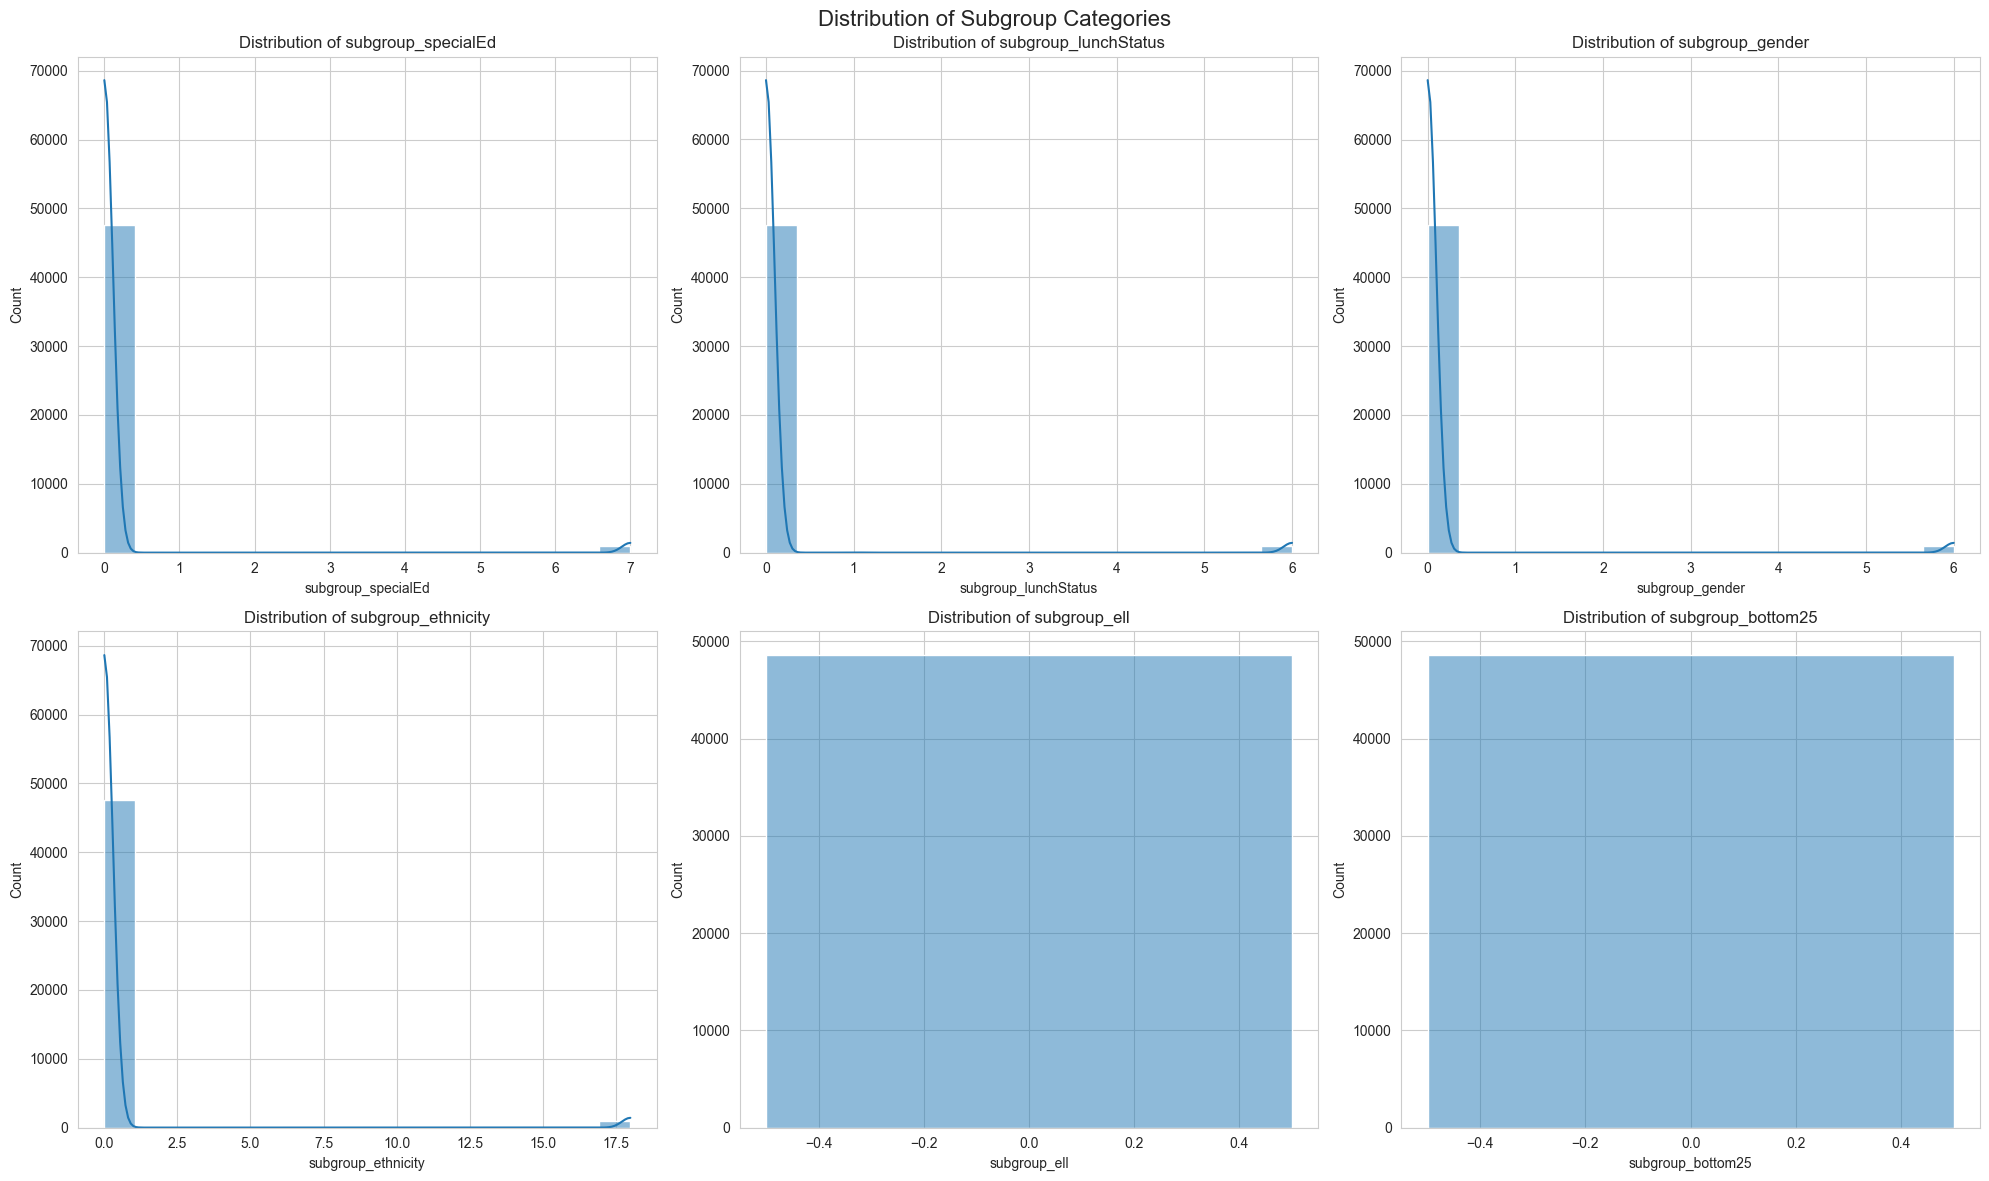


Value counts for subgroup_specialEd:
subgroup_specialEd
0    47605
7      984
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_lunchStatus:
subgroup_lunchStatus
0    47590
6      984
1       15
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_gender:
subgroup_gender
0    47605
6      984
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_ethnicity:
subgroup_ethnicity
0     47605
18      984
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_ell:
subgroup_ell
0    48589
Name: count, dtype: int64

--------------------------------------------------

Value counts for subgroup_bottom25:
subgroup_bottom25
0    48589
Name: count, dtype: int64

--------------------------------------------------


In [195]:
# Define the subgroup columns
subgroups = ['subgroup_specialEd', 'subgroup_lunchStatus', 'subgroup_gender', 
                    'subgroup_ethnicity', 'subgroup_ell', 'subgroup_bottom25']

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Distribution of Subgroup Categories', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot histograms for each subgroup
for i, column in enumerate(subgroups):
    sns.histplot(data=act_11_df, x=column, ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Print value counts for each subgroup
for column in subgroups:
    print(f"\nValue counts for {column}:")
    print(act_11_df[column].value_counts(dropna=False))
    print("\n" + "-"*50)


In [196]:
act_11_df.drop(columns=subgroups, inplace=True)

Merge with courses taken by same students in previous year (2017, grade 10).

In [197]:
courses_act_df = courses[(courses['year'] == 2017) & (courses['studentLevel'] == 10)]
courses_act_df = courses_act_df.reset_index(drop=True)

In [198]:
courses_act_df.head()

,courseSectionId,studentId,studentLevel,vanityId,year,schoolId
0,73319,46413,10,W H 1500-P,2017,224
1,73320,47091,10,Biology,2017,224
2,73321,46413,10,Enviro Sci,2017,224
3,73322,46705,10,Enviro Sci,2017,224
4,73327,50738,10,LIFE PE 9-12,2017,224


In [199]:
act_11_courses = act_11_df.merge(courses_act_df[['vanityId', 'schoolId', 'studentId']], on='studentId', how='left')

# Create binary features for each unique course vanityId
course_dummies = pd.get_dummies(act_11_courses['vanityId'], prefix='course')

# Aggregate the binary features and schoolId by studentId
act_11_courses_grouped = pd.concat([course_dummies, act_11_courses[['studentId', 'schoolId']]], axis=1)
act_11_courses_grouped = act_11_courses_grouped.groupby('studentId').agg({
    **{col: 'max' for col in course_dummies.columns},
    'schoolId': 'first'  # Take the first non-null schoolId for each student
})

# Merge the binary course features and schoolId back to act_11_df
act_11_df = act_11_df.merge(act_11_courses_grouped, on='studentId', how='left')

# Fill NaN values with 0 for course features (students not enrolled in a course)
course_columns = [col for col in act_11_df.columns if col.startswith('course_')]
act_11_df[course_columns] = act_11_df[course_columns].fillna(0)

# Merge act_11_df with schools_df to get school names
act_11_df = act_11_df.merge(schools_df[['id', 'name']], left_on='schoolId', right_on='id', how='left')

# Rename the 'name' column to 'school'
act_11_df = act_11_df.rename(columns={'name': 'school'})

# Drop the 'id' and 'schoolId' columns
act_11_df = act_11_df.drop(['id', 'schoolId'], axis=1)

In [200]:
act_11_df.head()

,studentId,level,year,dataSource,score,threshold,is_proficient,proficient_score,course_AAS:EngLA-10,course_AAS:Life-10,course_AAS:Math-10,course_AAS:Sci-10,course_AAS:SoSt-10,course_AAS:Vocat-10,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: EnvSc,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_US IR-P Adv,course_USHis 1877-P,course_USHis I Adv,course_U

In [201]:
school_dummies = pd.get_dummies(act_11_df['school'], prefix='school')
act_11_df = pd.concat([act_11_df, school_dummies], axis=1)

# Drop the original 'school' column
act_11_df = act_11_df.drop('school', axis=1)

In [202]:
act_11_df = act_11_df[act_11_df['score'] != 0]

In [203]:
act_11_df.head()

,studentId,level,year,dataSource,score,threshold,is_proficient,proficient_score,course_AAS:EngLA-10,course_AAS:Life-10,course_AAS:Math-10,course_AAS:Sci-10,course_AAS:SoSt-10,course_AAS:Vocat-10,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: EnvSc,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_US IR-P Adv,course_USHis 1877-P,course_USHis I Adv,course_U

In [204]:
actComposite_11_df = act_11_df[act_11_df['dataSource'] == 'value_actCompositeScore']
actMath_11_df = act_11_df[act_11_df['dataSource'] == 'value_actMathScore']

## Explore actMath_11_df

In [205]:
# Remove columns that are all False or all 0 in actMath_11_df
cols_to_drop = actMath_11_df.columns[(actMath_11_df == 0).all() | (actMath_11_df == False).all()]
actMath_11_df = actMath_11_df.drop(columns=cols_to_drop)

print(f"Removed {len(cols_to_drop)} columns that were all False or all 0.")

# Drop level, year, (same for all rows) and score, threshold (captured in is_proficient)
columns_to_drop = ['level', 'year', 'score', 'threshold', 'dataSource']
actMath_11_df.drop(columns=[col for col in columns_to_drop if col in actMath_11_df.columns], inplace=True)

Removed 9 columns that were all False or all 0.


In [206]:
# Shape should be (3837, 237)
print(actMath_11_df.shape)
actMath_11_df.head()

(3837, 238)


,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,course_VarFBII,course

In [207]:
# Check for class imbalance
actMath_11_df['is_proficient'].value_counts()

is_proficient
False    2234
True     1603
Name: count, dtype: int64

/var/folders/w3/z8qntdcx62v2qmj6z9fwfhrh0000gp/T/ipykernel_97549/2289246554.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=actMath_11_df, x='proficient_score', shade=True)


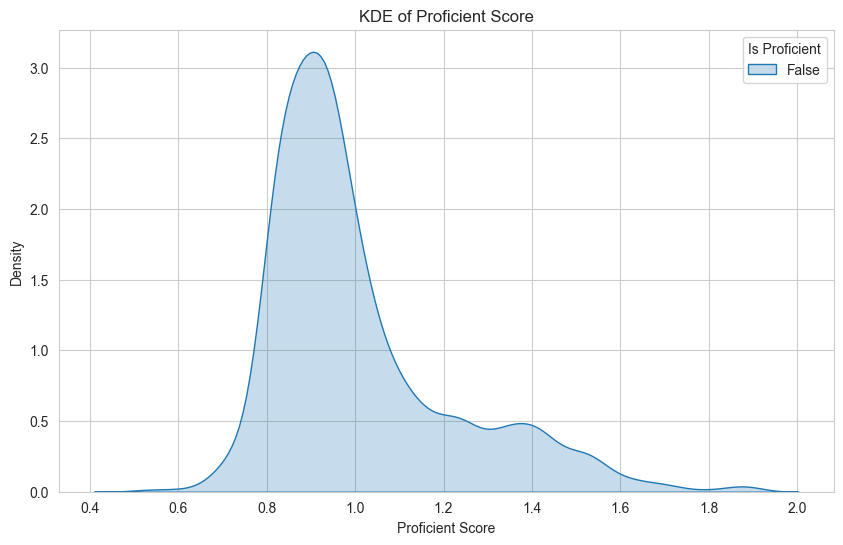

In [208]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=actMath_11_df, x='proficient_score', shade=True)
plt.title('KDE of Proficient Score')
plt.xlabel('Proficient Score')
plt.ylabel('Density')
plt.legend(title='Is Proficient', labels=['False', 'True'])
plt.show()

In [209]:
# Count the number of students enrolled in each course
course_enrollment = actMath_11_df.iloc[:, 2:].sum().sort_values(ascending=False)

# Print the number of students enrolled in each course, sorted by most popular
print("Number of students enrolled in each course:")
for course, count in course_enrollment.items():
    if count > 0:
        print(f"{course}: {count}")

Number of students enrolled in each course:
proficient_score: 3871.058823529412
course_Physical Sci: 1776.0
course_English Gr10: 1721.0
course_D&TSafetyEd: 1450.0
course_Health 9-12: 1394.0
course_Algebra I B: 1229.0
course_USHis I G10: 1199.0
school_High School C: 994.0
course_Mustang Advi: 994.0
school_High School D: 933.0
course_Eng Gr10 Adv: 927.0
course_ChemistryAdv: 735.0
course_USHis I Adv: 704.0
course_Geometry: 659.0
course_HEALTH 9-12: 647.0
course_DRIVERS ED: 609.0
course_US His-1877: 483.0
course_CareerPrep-B: 472.0
school_High School A: 442.0
course_Panther Adv: 442.0
school_High School B: 410.0
course_Alg II/Trig: 406.0
course_BullBogAdv: 340.0
course_LIFE PE 9-12: 308.0
course_Spanish 1: 283.0
course_FACS: 247.0
course_VarFBII: 208.0
course_Fund Agrisci: 186.0
course_Theatre I: 178.0
course_ALIITRIGH/A: 176.0
course_HS US 10 ADV: 172.0
course_Spanish 2: 171.0
course_ARMY LET II: 169.0
course_StudyHall912: 166.0
course_VisArtI.5C: 165.0
course_Fit/Cond: 147.0
course_Phy S

In [210]:
course_enrollment_top50 = course_enrollment.head(50)

Use only the 50 most enrolled courses.

In [211]:
actMath_11_top50_df = actMath_11_df.drop(columns=[col for col in actMath_11_df.columns if col.startswith('course_') and col not in course_enrollment_top50.index])

In [212]:
actMath_11_top50_df.head()

,studentId,is_proficient,proficient_score,course_ALIITRIGH/A,course_ARMY LET II,course_Agriscience,course_Alg II/Trig,course_Algebra I B,course_BAND MARCH,course_BANDCONCERT,course_BandMarch.5C,course_BullBogAdv,course_CareerPrep-B,course_ChemistryAdv,course_D&TSafetyEd,course_DRIVERS ED,course_Eng Gr10 Adv,course_English Gr10,course_FACS,course_Fit/Cond,course_Food Nutritn,course_Fund Agrisci,course_GEOM ADV,course_Geometry,course_Geometry Adv,course_HEALTH 9-12,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_Int Metl Fab,course_Intermed Agr,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_Music App,course_Mustang Advi,course_Panther Adv,course_Phy Sci Adv,course_Physical Sci,course_Psychology,course_Spanish 1,course_Spanish 2,course_StudyHall912,course_Theatre I,course_US His-1877,course_USHis I Adv,course_USHis I G10,course_VarFBII,course_VisArtI.5C,school_High School A,school_High School B,school_High School C,school_High School D
0,45054,False,0.529412,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,45054,False,0.529412,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
4,45440,False,0.941176,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,45440,False,0.941176,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,45440,False,0.941176,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


## Train models

In [213]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### Logistic regression with top50 courses, binary label

In [214]:
# Separate features and target variable
X = actMath_11_top50_df.drop(['studentId', 'is_proficient', 'proficient_score'], axis=1)
y = actMath_11_top50_df['is_proficient']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=actMath_11_top50_df['is_proficient'])

# Create a logistic regression model
model = LogisticRegression(penalty='l2', solver='lbfgs', random_state=123)
model.fit(X_train, y_train)
y_pred =model.predict(X_test)

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the top 10 most important features
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': np.abs(model.coef_[0])})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.93      0.83       447
        True       0.85      0.56      0.67       321

    accuracy                           0.77       768
   macro avg       0.80      0.74      0.75       768
weighted avg       0.79      0.77      0.76       768


Confusion Matrix:
[[415  32]
 [142 179]]

Top 10 Most Important Features:
                feature  importance
3    course_Alg II/Trig    1.691954
33   course_Phy Sci Adv    1.594910
4    course_Algebra I B    1.156335
23  course_HISTUS1877AC    1.076533
44    course_VisArtI.5C    1.002130
10  course_ChemistryAdv    0.988112
7   course_BandMarch.5C    0.953046
15          course_FACS    0.946260
8     course_BullBogAdv    0.935125
35    course_Psychology    0.925735


### Linear regression with top50 courses, continuous label

In [220]:
# Separate features and target variable
X = actMath_11_top50_df.drop(['studentId', 'is_proficient', 'proficient_score'], axis=1)
y = actMath_11_top50_df['proficient_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=actMath_11_top50_df['is_proficient'])

# Create a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred_continuous = model.predict(X_test)

# Should predict >1.0 if proficient, <1.0 if not proficient
threshold = 1.2  # ADJUST
y_pred_bool = y_pred_continuous >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

# Print the confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_bool, y_pred_bool))

# Print the top 10 most important features
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': np.abs(model.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

threshold= 1.2

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.93      0.92       644
        True       0.58      0.52      0.55       124

    accuracy                           0.86       768
   macro avg       0.74      0.72      0.73       768
weighted avg       0.86      0.86      0.86       768


Confusion Matrix:
[[596  48]
 [ 59  65]]

Top 10 Most Important Features:
                 feature    importance
47  school_High School C  1.302425e+11
31   course_Mustang Advi  1.302425e+11
32    course_Panther Adv  2.997088e+10
45  school_High School A  2.997088e+10
3     course_Alg II/Trig  1.618876e-01
0     course_ALIITRIGH/A  1.432599e-01
10   course_ChemistryAdv  1.029011e-01
33    course_Phy Sci Adv  9.511964e-02
4     course_Algebra I B  9.464047e-02
46  school_High School B  8.192498e-02


### Neural network with top50 courses, binary label

In [216]:
# Define a custom dataset
class TabularDataSet(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the neural network
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Prepare the data
X = actMath_11_top50_df.drop(['studentId', 'is_proficient', 'proficient_score'], axis=1)
y = actMath_11_top50_df['is_proficient']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=actMath_11_top50_df['is_proficient'])

# Create datasets and dataloaders
train_dataset = TabularDataSet(X_train, y_train)
test_dataset = TabularDataSet(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = X.shape[1]
model = Net(input_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predicted = (outputs > 0.5).float()
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        y_true.extend(batch_y.numpy())
        y_pred.extend(predicted.numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))




Epoch [10/100], Loss: 0.4392
Epoch [20/100], Loss: 0.5163
Epoch [30/100], Loss: 0.3892
Epoch [40/100], Loss: 0.3138
Epoch [50/100], Loss: 0.3537
Epoch [60/100], Loss: 0.3971
Epoch [70/100], Loss: 0.3172
Epoch [80/100], Loss: 0.3649
Epoch [90/100], Loss: 0.3110
Epoch [100/100], Loss: 0.3230
Test Accuracy: 78.52%

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83       447
         1.0       0.82      0.62      0.71       321

    accuracy                           0.79       768
   macro avg       0.79      0.76      0.77       768
weighted avg       0.79      0.79      0.78       768


Confusion Matrix:
[[403  44]
 [121 200]]


False negative (someone who is not proficient but predicted to be proficient) is worse than false positive, so focus on recall. 

In [217]:
courses_by_subject = {
    "Math": [
        "course_Algebra I B", "course_Algebra I A", "course_Algebra I", "course_AlgebraicCon",
        "course_Alg II/Trig", "course_ALIITRIGH/A", "course_Alg Esntls B", "course_Algebra II",
        "course_Alg II/TrigAC", "course_Geometry", "course_Geometry Adv", "course_GeometryACCE",
        "course_GEOM ADV", "course_Alg I B ACCE", "course_AlgEnrichmet"
    ],
    "Science": [
        "course_Physical Sci", "course_Phy Sci Adv", "course_Biology", "course_Chemistry",
        "course_ChemistryAdv", "course_Biology Adv", "course_BIOLOGY ADV", "course_Anat/Physio", 
        "course_Marine Sci", "course_Ear/SpaceSci", "course_Enviro Sci", "course_For/Cri Inve", 
        "course_Forestry", "course_Intermed Agr", "course_Agriscience", "course_Advanced Agr", 
        "course_Fund Agrisci"
    ],
    "English": [
        "course_English Gr10", "course_Eng Gr10 Adv", "course_English Gr11", "course_EngLang,BS10", 
        "course_Eng Ess 10", "course_Eng Ess 11", "course_Eng Ess 11", "course_EngGr9-CR", 
        "course_EngEss: Phy Sci", "course_Ess: Phy Sci", "course_English Gr 9", "course_EnglGr10ACCE"
    ],
    "History": [
        "course_USHis I G10", "course_USHis I Adv", "course_US His-1877", "course_HISTUS1877AC", 
        "course_USHis InD-P", "course_HS US 10 ADV", "course_Enviro Sci", "course_USHisIG10ACC", 
        "course_USHis 1877-P", "course_WH 1500-P", "course_WH 1500-P Adv", "course_WH1500-P-CR"
    ],
    "Foreign Language": [
        "course_Spanish 1", "course_Spanish 2", "course_Spanish 3", "course_SPANISH I", 
        "course_SPANISH II", "course_SpanIACC", "course_SPAN II ACCE", "course_FrenchIACCE", 
        "course_German1ACCES", "course_LATIN 1 ACC"
    ]
}